## Training a Vanilla RNN for Activity Recognition

---

### **1. Recap & Motivation**

**What we learned in Notebook 1**

- The **HAR dataset** contains sequences of smartphone sensor signals:  
  - Each sample = **128 timesteps × 9 features** (accelerometer + gyroscope axes).  
  - Each label = **one of 6 activities** (Walking, Sitting, etc.).  

- We saw how an **RNN** works step by step:  
  - At each timestep $t$, it updates a **hidden state $h_t$**.  
  - The hidden state carries information forward like a **memory**.  
  - After the last timestep ($T=128$), the final hidden state $h_{128}$ is used to classify the activity.  

- We explored 3 cases:  
  1. **Tiny RNN** (batch=1, hidden=1) → just 1 number carried forward.  
  2. **Small RNN** (batch=1, hidden=3) → a small vector storing richer patterns.  
  3. **Practical RNN** (batch=32, hidden=32) → realistic batch training setup.

**What changes in this notebook?**

In Notebook 1, we only **ran forward passes** to build intuition.  
Now, we will **train a real model**:

- Build a **Vanilla RNN Classifier** with PyTorch.  
- Train it on the **training set** of HAR sequences.  
- Evaluate its performance on the **test set**.  

This takes us from “how RNNs work” → to “can they actually recognize activities?”

**Why this matters**

- **Sequence classification** problems (like HAR) are everywhere:  
  - Human activity recognition (wearables, smartphones).  
  - Speech recognition.  
  - Video action recognition.  

- **Vanilla RNNs** are the historical foundation of sequence models.  
  - They introduced the idea of **using past information to inform the present**.  
  - Even though they have limitations (vanishing gradients), they remain an essential starting point.  

**Notebook Goals**

By the end of this notebook, we will:

1. Load and batch the HAR dataset for PyTorch training.  
2. Define a simple **RNN → Linear → Softmax** classifier.  
3. Train it with **CrossEntropyLoss** and **Adam optimizer**.  
4. Evaluate it with accuracy and a **confusion matrix**.  
5. Reflect on **why vanilla RNNs sometimes fail**, and how that leads us to LSTMs and GRUs.  


➡️ Next, let’s prepare the **train and test datasets** so that we can feed them into our RNN.

---

### **2. Dataset Preparation (Train/Test) — Self-Contained**

**What does one sample look like?**

- Each sample = a **2.56-second** window of smartphone signals.  
- Shape = **128 timesteps × 9 features** (3 body acc + 3 total acc + 3 gyro axes).  
- Each label = one of **6 activity classes**.

So, if there are $N$ samples:
- `X` has shape $(N, 128, 9)$  
- `y` has shape $(N,)$ with class indices in $\{0,\dots,5\}$

**Why batching?**

We train faster and more stably by processing **multiple sequences in parallel**. In this notebook, we’ll use `batch_size = 32` unless noted otherwise.


**End-to-end steps in this section**

1) **Load** the nine raw signal files per split and **stack** them → $(N,128,9)$  
2) **Load labels** and convert to indices $\{0..5\}$  
3) **Standardize** features channel-wise using **train statistics** only  
4) **Wrap** as tensors → `TensorDataset` → `DataLoader`  
5) **Sanity check** shapes and visualize a couple of sequences

*Note:* All HAR windows already have fixed length (128), so **no padding** is needed in NB02.



In [2]:
# Imports & configuration for this section (self-contained)

import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Activity label mapping (HAR uses 1..6 in files; we convert to 0..5)
ACTIVITY_MAP = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING",
}
NUM_CLASSES = 6

# IMPORTANT: Set this to your local "UCI HAR Dataset" folder
BASE_DIR = Path("UCI HAR Dataset")  
assert BASE_DIR.exists(), f"BASE_DIR does not exist: {BASE_DIR}"
print("Using dataset folder:", BASE_DIR)


Using dataset folder: UCI HAR Dataset


In [3]:
# Utilities to load HAR raw inertial signals (9 channels) + labels, self-contained

SIGNAL_NAMES = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "total_acc_x","total_acc_y","total_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
]

def load_split(split: str, base_dir: Path):
    """
    Load HAR raw inertial signals and labels for a split ("train" or "test").

    Returns:
        X: np.ndarray, shape (N, 128, 9), float32
        y: np.ndarray, shape (N,), int64 in {0..5}
        subjects: np.ndarray, shape (N,), int64 in {1..30}
    """
    sig_dir = base_dir / split / "Inertial Signals"
    matrices = []
    for name in SIGNAL_NAMES:
        fpath = sig_dir / f"{name}_{split}.txt"
        arr = np.loadtxt(fpath, dtype=np.float32)   # (N, 128)
        matrices.append(arr[:, :, None])            # -> (N, 128, 1)
    X = np.concatenate(matrices, axis=2)            # (N, 128, 9)

    y = np.loadtxt(base_dir / split / f"y_{split}.txt", dtype=np.int64)  # 1..6
    y = y - 1  # -> {0..5}

    subjects = np.loadtxt(base_dir / split / f"subject_{split}.txt", dtype=np.int64)
    return X, y, subjects

# Load both splits fresh in NB02
X_train_np, y_train_np, subj_train = load_split("train", BASE_DIR)
X_test_np,  y_test_np,  subj_test  = load_split("test",  BASE_DIR)

print("Train X:", X_train_np.shape, "(N, 128, 9)")
print("Train y:", y_train_np.shape,  "(N,) in {0..5}")
print("Test  X:", X_test_np.shape)
print("Test  y:", y_test_np.shape)
print("Train subjects range:", int(subj_train.min()), "to", int(subj_train.max()))


Train X: (7352, 128, 9) (N, 128, 9)
Train y: (7352,) (N,) in {0..5}
Test  X: (2947, 128, 9)
Test  y: (2947,)
Train subjects range: 1 to 30


In [4]:
# Channel-wise standardization using TRAIN statistics only (recommended)

EPS = 1e-8

# Compute per-channel mean/std over (N, T) for the TRAIN split
train_mean = X_train_np.mean(axis=(0, 1), keepdims=True)  # (1,1,9)
train_std  = X_train_np.std(axis=(0, 1), keepdims=True)   # (1,1,9)

X_train_std = (X_train_np - train_mean) / (train_std + EPS)
X_test_std  = (X_test_np  - train_mean) / (train_std + EPS)  # IMPORTANT: use train stats!

print("Sanity check (standardized) ->",
      "train mean ~", np.round(X_train_std.mean(axis=(0,1)), 4),
      "train std ~",  np.round(X_train_std.std(axis=(0,1)), 4))


Sanity check (standardized) -> train mean ~ [ 0.      0.      0.      0.0019  0.      0.      0.     -0.      0.    ] train std ~ [1.     1.     1.     0.9997 1.0002 1.     1.     1.     1.    ]


In [5]:
# Convert to PyTorch tensors and build DataLoaders (batch-first tensors)

X_train_t = torch.from_numpy(X_train_std)  # (N, 128, 9) float32
y_train_t = torch.from_numpy(y_train_np)   # (N,)        int64

X_test_t  = torch.from_numpy(X_test_std)
y_test_t  = torch.from_numpy(y_test_np)

BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),
                          batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Inspect one batch
xb, yb = next(iter(train_loader))
print("Batch X shape (batch-first):", tuple(xb.shape))  # (32, 128, 9)
print("Batch y shape:", tuple(yb.shape))                # (32,)


Batch X shape (batch-first): (32, 128, 9)
Batch y shape: (32,)


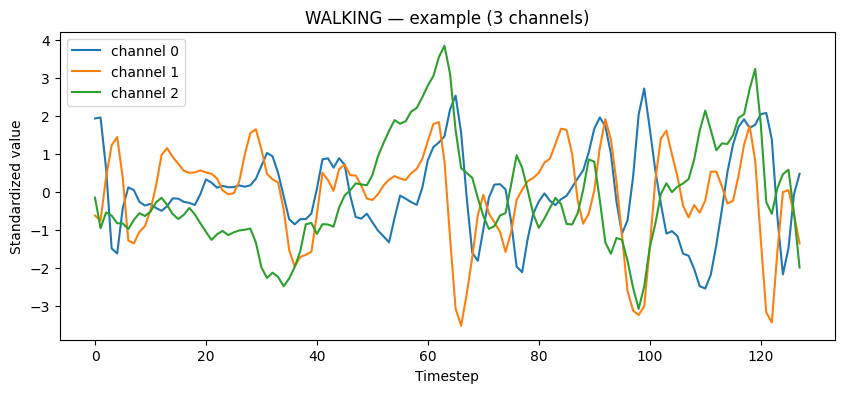

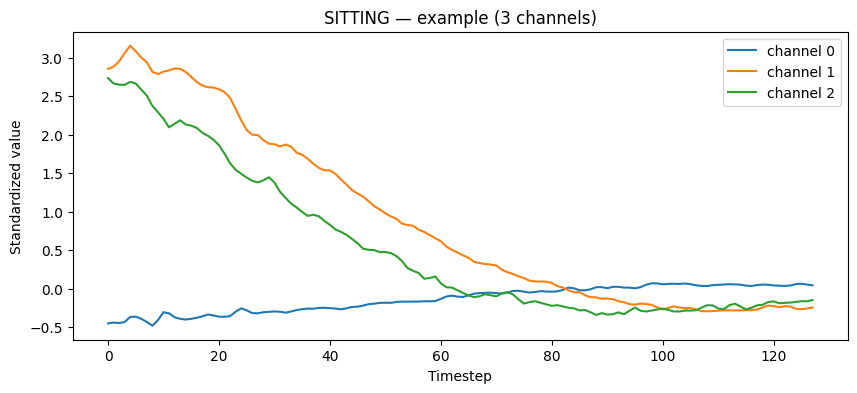

In [6]:
# Quick visual sanity checks: one example per activity (3 channels plotted)
import matplotlib.pyplot as plt
import numpy as np

def find_first_index(y_np, class_index):
    idxs = np.where(y_np == class_index)[0]
    return int(idxs[0]) if idxs.size > 0 else None

def plot_three_channels(seq_128x9, title, channels=(0,1,2)):
    t = np.arange(seq_128x9.shape[0])
    plt.figure(figsize=(10,4))
    for c in channels:
        plt.plot(t, seq_128x9[:, c], label=f"channel {c}")
    plt.xlabel("Timestep")
    plt.ylabel("Standardized value")
    plt.title(title)
    plt.legend()
    plt.show()

# Example indices (0=WALKING, 3=SITTING) if available
idx_walk = find_first_index(y_train_np, 0)
idx_sit  = find_first_index(y_train_np, 3)

if idx_walk is not None:
    plot_three_channels(X_train_std[idx_walk], "WALKING — example (3 channels)")

if idx_sit is not None:
    plot_three_channels(X_train_std[idx_sit], "SITTING — example (3 channels)")


**Reflection**

- **Shapes:** We have $(N, 128, 9)$ inputs and $(N,)$ labels for both train and test.  
- **Standardization:** Using train statistics only helps stabilize optimization and avoids leakage.  
- **Batching:** Our `DataLoader` yields `(batch, 128, 9)` tensors by default (**batch-first**).  
  <br>
Later, we will either **permute** to time-first `(128, batch, 9)` or create the RNN with `batch_first=True`.  

> **Understanding the 3-Channel Visualization**

The UCI HAR dataset provides **9 raw sensor channels**, but here we are visualizing only **3 representative channels** for clarity. These typically correspond to:

- **Body accelerometer** (linear acceleration from the body)  
- **Total accelerometer** (overall acceleration, including gravity)  
- **Gyroscope axis** (angular velocity)  

> **Why does "Walking" look mean-reverting around 0?**

When a person walks, motion is **cyclical**. Each stride causes accelerations that swing positive and negative, averaging out around zero over time.  
- All three channels show **oscillations centered near 0**, reflecting alternating steps.  
- This mean-reverting pattern is a strong indicator of **dynamic movement**.

> **Why does "Sitting" look static?**

When a person sits:  
- One channel remains **nearly flat**, showing almost no variation (the body is stationary along one axis).  
- The other two channels gradually **decline toward 0** as small movements or vibrations fade out.  
- This produces a clear contrast with walking — instead of rhythmic oscillations, we see **static or slowly stabilizing signals**.

>**Factors that Distinguish Activities**

These patterns are critical because each of the **6 activities** (walking, walking upstairs, walking downstairs, sitting, standing, laying) produces a **distinct sensor signature**:  
- **Dynamic activities** (walking, stairs) → oscillatory patterns across channels.  
- **Static activities** (sitting, standing, laying) → mostly flat or slowly stabilizing channels.  

By observing how multiple channels behave together, we can begin to separate activities before even training a model.

---


✅ Instruction</br>
Find the first training example for class LAYING (label index 5), and plot channels 0, 1, 2 over time from the standardized array.


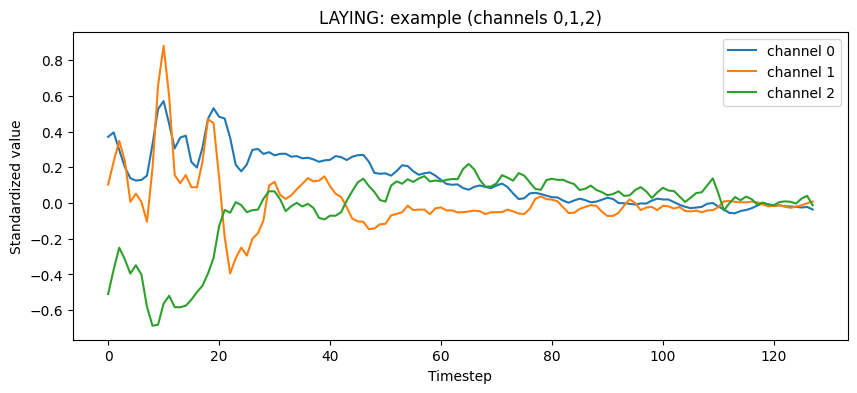

In [8]:
# CT_Task 1 — Plot 3 channels (0,1,2) for LAYING

import numpy as np
import matplotlib.pyplot as plt

def CT_find_first_index(y_np, class_index):
    idxs = np.where(y_np == class_index)[0]
    return int(idxs[0]) if len(idxs) > 0 else None

CT_idx_laying = CT_find_first_index(y_train_np, 5)
CT_seq_laying = X_train_std[CT_idx_laying]         # expect (128, 9)
CT_channels = (0, 1, 2)

t = np.arange(CT_seq_laying.shape[0])
plt.figure(figsize=(10, 4))
for c in CT_channels:
    plt.plot(t, CT_seq_laying[:, c], label=f"channel {c}")
plt.xlabel("Timestep")
plt.ylabel("Standardized value")
plt.title("LAYING: example (channels 0,1,2)")
plt.legend()
plt.show()


---

### **3. Saving Preprocessed Datasets for Later Use**

So far in this notebook, we loaded the raw inertial signals, standardized them,  
and prepared PyTorch tensors for training.  

➡️ But in the next notebooks (NB03, NB04), our focus will **not** be on preprocessing again.  
Instead, we will be analyzing hidden states, visualizing temporal dynamics, and  
studying RNN limitations. For that, we want to **reuse the exact same standardized dataset**  
without re-running all the preprocessing steps each time.

Therefore, we will **save the processed dataset** now, so later notebooks can simply load it in.

**Why save datasets in both `.npy` and `.csv`?**

We’ll save the standardized sequences and labels in two formats:

- **`.npy` (NumPy binary)**  
  - Keeps the exact array shape $(N, 128, 9)$, preserves `dtype`, and **loads very fast**.  
  - Ideal for deep learning workflows.  
  - Downside: not human-readable.

- **`.csv` (comma-separated values)**  
  - **Human-readable** and easy to inspect in Excel or even a text editor.  
  - Each sequence row is **flattened** from $128 \times 9$ into **1152 columns** + metadata columns.  
  - Slightly larger files, and requires reshaping back to $(128, 9)$ when loading.

👉 In NB03, we will **use CSVs by default** (to practice reshaping and keep things transparent),  
but we will also show how to use the **faster `.npy` files**. This way, you get the best of both worlds.



In [9]:
# Save preprocessed arrays as .npy (fast, shape-preserving)
import numpy as np

np.save("X_train_std.npy", X_train_std)  # (N_train, 128, 9), float32
np.save("y_train.npy",     y_train_np)   # (N_train,), int64
np.save("X_test_std.npy",  X_test_std)   # (N_test, 128, 9)
np.save("y_test.npy",      y_test_np)    # (N_test,)

# Also save the channel-wise normalization stats so other notebooks can reuse them if needed
np.savez("standardization_stats.npz", train_mean=train_mean, train_std=train_std)

print("Saved: X_train_std.npy, y_train.npy, X_test_std.npy, y_test.npy, standardization_stats.npz")


Saved: X_train_std.npy, y_train.npy, X_test_std.npy, y_test.npy, standardization_stats.npz


**A note on `.npy` vs `.npz`**

When saving NumPy arrays, we often use two related formats:

- **`.npy`**: Stores a **single array** per file.  
  Example: `X_train_std.npy` contains only the training inputs $(N_{\text{train}}, 128, 9)$.  
  This is efficient, keeps the shape intact, and loads very quickly.  

- **`.npz`**: Stores **multiple arrays together** in one zipped container.  
  Example: `standardization_stats.npz` contains both `train_mean` and `train_std`.  
  Instead of creating two separate `.npy` files, we can keep them neatly grouped.

We chose `.npy` for the **datasets** (since they are large and independent),  
and `.npz` for the **normalization statistics** (small, logically grouped).  

👉 This way, each notebook can easily reload exactly what it needs —  
large arrays load fast from `.npy`, while small supporting stats stay tidy in one `.npz`.


In [10]:
# Save preprocessed arrays as CSV (human-readable; flattened per row)
import pandas as pd

# Column name builder: channel_order × timestep
channel_order = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "total_acc_x","total_acc_y","total_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
]
def make_flat_columns():
    cols = []
    for ch in channel_order:
        for t in range(128):
            cols.append(f"{ch}_t{t:03d}")
    return cols

flat_cols = make_flat_columns()

def to_wide_df(X_std: np.ndarray, y: np.ndarray, subjects: np.ndarray) -> pd.DataFrame:
    """
    X_std: (N, 128, 9) standardized
    y:     (N,)        class indices in {0..5}
    subjects: (N,)     subject IDs
    returns a DataFrame of shape (N, 1152 + 2) with columns:
      [label, subject, body_acc_x_t000, ..., body_gyro_z_t127]
    """
    N = X_std.shape[0]
    X_flat = X_std.reshape(N, -1)  # (N, 128*9 = 1152)
    df = pd.DataFrame(X_flat, columns=flat_cols)
    df.insert(0, "subject", subjects.astype(int))
    df.insert(0, "label",   y.astype(int))  # class index {0..5}
    return df

train_df = to_wide_df(X_train_std, y_train_np, subj_train)
test_df  = to_wide_df(X_test_std,  y_test_np,  subj_test)

train_df.to_csv("har_train_standardized.csv", index=False)
test_df.to_csv("har_test_standardized.csv",   index=False)

# Save a small README-style CSV with metadata / mapping (optional but helpful)
meta = pd.DataFrame({
    "key": ["label_index_map", "channels_order", "timesteps", "standardized", "note"],
    "value": [
        "{0: WALKING, 1: WALKING_UPSTAIRS, 2: WALKING_DOWNSTAIRS, 3: SITTING, 4: STANDING, 5: LAYING}",
        str(channel_order),
        "128",
        "True (z-score per channel using train stats)",
        "Rows are one window each; columns are flattened as <channel>_t000..t127"
    ],
})
meta.to_csv("har_metadata.csv", index=False)

print("Saved: har_train_standardized.csv, har_test_standardized.csv, har_metadata.csv")


Saved: har_train_standardized.csv, har_test_standardized.csv, har_metadata.csv


✅ **CSV layout (wide format)**

- One row = **one window** (2.56 s).  
- First columns: `label` (class index $0..5$), `subject` (ID $1..30$).  
- Then **1152** feature columns: ${channel}\_t000, \dots, {channel}\_t127$ for each of the 9 channels.  

When we load CSVs in NB03, we will:
1) Read the row,
2) Strip off `label`/`subject`,
3) Reshape the **1152** values back to $(128, 9)$.

> We also saved `.npy` files (fast loading, keeps $(N,128,9)$ shape) and `standardization_stats.npz` if we ever need to reproduce the scaling.

**🔍 How do `.npy`, `.npz`, and `.csv` look inside?**

If you try to open these files in a text editor like Notepad, here’s what you’ll see:

- **`.csv`**  
  - Human-readable text.  
  - Each row is numbers separated by commas.  
  - Example (flattened sequence with label):
    ```
    0.12, -0.45, 0.33, ..., -0.04, 3
    ```
    Easy to inspect, but shape information (128×9) is *lost* — we must reshape.

- **`.npy`**  
  - Binary format: appears as *nonsense characters* in Notepad.  
  - That’s because it encodes array shape, dtype, and values in an efficient way.  
  - Think of it as a “locked box”: not human-readable, but NumPy can open it instantly with `np.load("file.npy")`.

- **`.npz`**  
  - A *zipped collection* of multiple `.npy` arrays.  
  - In Notepad it also looks like gibberish.  
  - But inside, it’s neatly storing several arrays with names (like `train_mean`, `train_std`).  
  - We can access them with `data["train_mean"]` after loading.

✅ **Analogy**:  
- `.csv` = writing everything out longhand so anyone can read it.  
- `.npy` = a sealed container, fast to store and retrieve but not meant for direct reading.  
- `.npz` = a zip folder containing several `.npy` containers.

This way, you know *why* some files look human-readable and others don’t, and why we use all three in different contexts.

---


✅ Instruction</br>
Load the CSV file you saved earlier into a DataFrame CT_df, set CT_df_shape = CT_df.shape, and print it.


In [11]:
# CT_Task 2 — Load CSV → DataFrame and print shape

import os
import pandas as pd

CT_csv_path = "har_train_standardized.csv"  # e.g., "./har_sequences.csv"
assert os.path.exists(CT_csv_path), "CSV path does not exist. Please point to the saved CSV."

CT_df = pd.read_csv(CT_csv_path)
CT_df_shape = CT_df.shape
print("CT_df_shape:", CT_df_shape)


CT_df_shape: (7352, 1154)


✅ Instruction
</br>
From CT_df, create CT_df_head = CT_df.head(5) and CT_df_first5cols = CT_df.columns[:5].tolist(), then print both.


In [12]:
# CT_Task 3 — Head + first 5 columns

import pandas as pd

assert 'CT_df' in globals(), "CT_df not found. Complete the previous task first."

CT_df_head = CT_df.head()
CT_df_first5cols = CT_df.columns[:5].tolist()
print("CT_df_first5cols:", CT_df_first5cols)
CT_df_head


CT_df_first5cols: ['label', 'subject', 'body_acc_x_t000', 'body_acc_x_t001', 'body_acc_x_t002']


,label,subject,body_acc_x_t000,body_acc_x_t001,body_acc_x_t002,body_acc_x_t003,body_acc_x_t004,body_acc_x_t005,body_acc_x_t006,body_acc_x_t007,...,body_gyro_z_t118,body_gyro_z_t119,body_gyro_z_t120,body_gyro_z_t121,body_gyro_z_t122,body_gyro_z_t123,body_gyro_z_t124,body_gyro_z_t125,body_gyro_z_t126,body_gyro_z_t127
0,4,1,0.004195,0.090382,0.522800,0.504396,-0.388833,0.045954,0.072998,0.175121,...,-0.022515,0.011355,0.027480,-0.018674,0.524570,-0.383995,0.023736,0.069621,0.002059,-0.006098
1,4,1,0.008882,-0.035921,-0.248912,0.518968,-0.390775,0.031962,0.040832,0.018201,...,-0.017749,-0.004941,-0.056389,-0.029231,0.516548,-0.407517,0.011505,-0.096289,-0.022576,-0.011386
2,4,1,0.021396,0.038806,-0.052801,0.529294,-0.380643,0.012915,0.063155,0.001534,...,-0.014922,0.014447,-0.042089,-0.117119,0.526618,-0.406656,-0.014006,-0.051006,-0.020981,-0.010788
3,4,1,-0.005832,-0.080853,0.012439,0.516144,-0.414897,0.024196,-0.093500,-0.031605,...,-0.044091,0.003123,-0.007706,-0.040311,0.523517,-0.414672,-0.014239,-0.018754,0.007270,-0.051244
4,4,1,0.003716,-0.029133,-0.122264,0.521627,-0.402940,-0.015813,-0.049024,-0.020407,...,-0.013904,-0.013821,0.062900,0.044488,0.513983,-0.389542,0.006482,0.037129,0.030447,-0.039880


---

### **4. Define the Vanilla RNN Classifier**

**Architecture (what we will build)**

We will build the simplest useful sequence classifier:

```text
Input sequence (batch, 128, 9)
│
▼
nn.RNN (hidden_size = H, num_layers = 1, batch_first = True)
│
├─ out: all hidden states (batch, 128, H)
└─ h_n: final hidden state (1, batch, H)
│
▼
Take the last hidden state h_T → (batch, H)
│
▼
Linear (H → 6 classes) → logits (batch, 6)
│
▼
CrossEntropyLoss (applies softmax internally)
```

**Key choices:**
- **Batch-first** = `True` so our inputs are `(batch, seq_len, input_size) = (B, 128, 9)`.
- **One recurrent layer**, **unidirectional**, **tanh** nonlinearity (default).
- We will start with a modest **hidden size** (e.g., `H = 32`) to keep CPU runtime low.

**Why take the *last* hidden state?**

For **sequence classification** (our HAR task), one sequence → one label.  
The **last hidden state** $h_T$ acts as a **summary** of the entire 128-timestep window.  
We map $h_T$ through a linear layer to obtain 6 logits (one per activity class).

**Loss function and outputs**

We will use **`nn.CrossEntropyLoss`**, which:
- expects **logits** of shape `(batch, num_classes)`,  
- expects **target class indices** in `{0, …, 5}`,  
- **includes softmax internally**, so we **do not** apply softmax before the loss.

(We will still use `softmax` later **only** for inspection/printing probabilities.)

**What hyperparameters matter here?**

- `hidden_size (H)`: memory capacity (e.g., 32 or 64 are good starters on CPU).
- `num_layers`: depth in the time dimension (we keep it `1` for now).
- `nonlinearity`: `"tanh"` (default) or `"relu"`; we’ll use `"tanh"` as a classic vanilla RNN.
- `bidirectional`: `False` here (we’ll keep it simple and fast).

We will **verify shapes with a dry run** on one batch before we start training.




In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3.5 Define the model class (batch-first RNN → last hidden state → linear)
class RNNClassifier(nn.Module):
    def __init__(self, input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh"):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,   # (batch, seq, input)
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: (batch, seq_len, input_size)
        returns: logits (batch, num_classes)
        """
        # out: (batch, seq_len, hidden_size)
        # h_n: (num_layers, batch, hidden_size)
        out, h_n = self.rnn(x)
        last_hidden = h_n[-1]          # (batch, hidden_size)
        logits = self.fc(last_hidden)   # (batch, num_classes)
        return logits

# Instantiate a small model for CPU-friendly training
model = RNNClassifier(input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh")
print(model)


RNNClassifier(
  (rnn): RNN(9, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [14]:
# Parameter count (helps students connect capacity ↔ performance/compute)
def count_params(m: nn.Module):
    return sum(p.numel() for p in m.parameters())

total_params = count_params(model)
print(f"Total parameters: {total_params:,}")


Total parameters: 1,574


In [15]:
# Dry-run forward pass on one real batch to verify shapes end-to-end
model.eval()
with torch.no_grad():
    xb, yb = next(iter(train_loader))     # from Section 2 DataLoader
    logits = model(xb)                    # (batch, 6)
    probs  = F.softmax(logits, dim=1)     # only for inspection
    pred   = probs.argmax(dim=1)          # predicted class indices

print("Input batch shape :", tuple(xb.shape))       # (B, 128, 9)
print("Logits shape      :", tuple(logits.shape))   # (B, 6)
print("Probs row sums    :", probs[0].sum().item()) # ~1.0
print("Targets shape     :", tuple(yb.shape))       # (B,)
print("Pred shape        :", tuple(pred.shape))     # (B,)
print("First 5 targets   :", yb[:5].tolist())
print("First 5 preds     :", pred[:5].tolist())


Input batch shape : (32, 128, 9)
Logits shape      : (32, 6)
Probs row sums    : 1.0
Targets shape     : (32,)
Pred shape        : (32,)
First 5 targets   : [5, 5, 4, 4, 1]
First 5 preds     : [3, 3, 5, 5, 2]


**Sanity-check: what just happened?**

- We passed a batch of sequences `(batch, 128, 9)` into the model.
- The RNN produced all hidden states and the **final hidden state** for each sequence.
- We mapped the **final hidden state** through a linear layer to obtain **logits** `(batch, 6)`.
- We converted logits to probabilities using **softmax** (for display only).
- Targets are **class indices** in `{0..5}`, exactly what `CrossEntropyLoss` expects.

If these shapes look correct and the code runs without error, we are ready to **train**.

---


✅ Instruction </br>
Define `CT_rnn_alt = nn.RNN(input_size=9, hidden_size=8, num_layers=2, nonlinearity='relu', batch_first=True) and CT_fc_alt = nn.Linear(8, NUM_CLASSES)`.


In [16]:
# CT_Task 4 — Alternate vanilla RNN config

import torch
import torch.nn as nn

CT_rnn_alt = nn.RNN(
    input_size=9,
    hidden_size=8,
    num_layers=2,
    nonlinearity='relu',
    batch_first=True
)
CT_fc_alt = nn.Linear(8, NUM_CLASSES)
print(CT_rnn_alt)
print(CT_fc_alt)


RNN(9, 8, num_layers=2, batch_first=True)
Linear(in_features=8, out_features=6, bias=True)


---

### **5. Training Loop**

**Objective, loss, and optimizer**

Our task is **multi-class sequence classification**: each input sequence (shape $128 \times 9$) maps to **one** activity label among 6 classes.

- **Model output:** logits of shape $(\text{batch}, 6)$
- **Targets:** class indices in $\{0,\dots,5\}$ of shape $(\text{batch},)$
- **Loss:** `CrossEntropyLoss` (which internally applies softmax to logits)
- **Optimizer:** Adam (good default on CPU)
- **(Optional) Gradient clipping:** helps stabilize RNN training by preventing exploding gradients

We’ll train for a small number of epochs (e.g., 8–12) to keep runtime under a few minutes on CPU.

**Metrics**

We’ll track:

- **Training loss** (average cross-entropy over training batches)
- **Validation/test accuracy** (fraction of correct predictions)
- (Loss on validation can also be tracked, but accuracy is typically more interpretable for students here.)

**Training flow (per epoch)**

1. `model.train()`  
2. Loop over `train_loader`:
   - Forward → compute loss → `loss.backward()` → optimizer step  
   - (Optional) gradient clipping after backward, before `optimizer.step()`
3. `model.eval()` on `test_loader` (no gradients) to compute accuracy
4. Log and plot curves

We’ll also print a short progress line each epoch (loss & accuracy).



In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time

# 4.4 Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# (Optional) gradient clipping settings
USE_CLIP = True
MAX_NORM = 5.0


In [18]:
# 4.5 Utility: accuracy on a batch (logits & targets)
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """
    logits: (batch, num_classes)
    targets: (batch,)
    returns: accuracy in [0,1]
    """
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


In [19]:
# Train / Eval loops

def train_one_epoch(model, loader, optimizer, criterion, clip=USE_CLIP, max_norm=MAX_NORM):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    
    for xb, yb in loader:
        # Forward
        logits = model(xb)            # (batch, 6)
        loss = criterion(logits, yb)  # scalar

        # Backward
        optimizer.zero_grad()
        loss.backward()
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        # Running stats
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total_examples += xb.size(0)
    
    avg_loss = total_loss / total_examples
    avg_acc  = total_correct / total_examples
    return avg_loss, avg_acc

@torch.no_grad()
def evaluate(model, loader, criterion=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for xb, yb in loader:
        logits = model(xb)
        if criterion is not None:
            total_loss += criterion(logits, yb).item() * xb.size(0)
        total_correct += (logits.argmax(dim=1) == yb).sum().item()
        total_examples += xb.size(0)

    avg_loss = (total_loss / total_examples) if criterion is not None else None
    avg_acc  = total_correct / total_examples
    return avg_loss, avg_acc


In [20]:
# Train for a few epochs (CPU-friendly)
EPOCHS = 10

history = {
    "train_loss": [],
    "train_acc":  [],
    "test_loss":  [],
    "test_acc":   [],
}

t0 = time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    te_loss, te_acc = evaluate(model, test_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc*100:5.1f}% | "
          f"test_loss={te_loss:.4f} acc={te_acc*100:5.1f}%")

t1 = time()
print(f"Total training time ~ {t1 - t0:.1f}s (CPU)")


Epoch 01 | train_loss=1.1554 acc= 51.8% | test_loss=0.9018 acc= 60.9%
Epoch 02 | train_loss=0.7338 acc= 66.2% | test_loss=0.8148 acc= 61.5%
Epoch 03 | train_loss=0.6383 acc= 68.9% | test_loss=0.7367 acc= 65.0%
Epoch 04 | train_loss=0.6057 acc= 71.7% | test_loss=0.7592 acc= 65.6%
Epoch 05 | train_loss=0.5659 acc= 75.8% | test_loss=0.6271 acc= 74.3%
Epoch 06 | train_loss=0.4892 acc= 80.8% | test_loss=0.6010 acc= 77.5%
Epoch 07 | train_loss=0.4188 acc= 84.0% | test_loss=0.6980 acc= 76.9%
Epoch 08 | train_loss=0.3798 acc= 85.9% | test_loss=0.6575 acc= 81.4%
Epoch 09 | train_loss=0.3358 acc= 88.7% | test_loss=0.6023 acc= 83.8%
Epoch 10 | train_loss=0.2948 acc= 90.7% | test_loss=0.6328 acc= 84.8%
Total training time ~ 43.2s (CPU)


In [21]:
# Save the trained model weights
torch.save(model.state_dict(), "rnn_har.pth")
print("Model saved as rnn_har.pth")

Model saved as rnn_har.pth


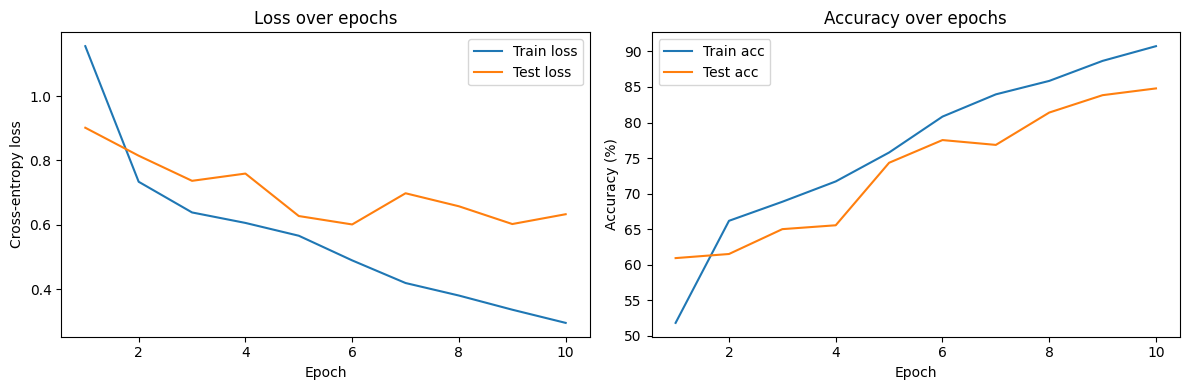

In [22]:
# Plot training curves (loss and accuracy)

import matplotlib.pyplot as plt

epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["test_loss"],  label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, [a*100 for a in history["train_acc"]], label="Train acc")
plt.plot(epochs, [a*100 for a in history["test_acc"]],  label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over epochs")
plt.legend()

plt.tight_layout()
plt.show()


**Reflection**

- We trained a **vanilla RNN classifier** end-to-end on HAR.  
- The model learned to map sequences $(128 \times 9)$ to one of **6 activities**.  
- We tracked **loss** and **accuracy** over epochs, confirming learning progress.  
- If training is unstable, we can:
  - Lower the learning rate (e.g., from $1\text{e-}3$ to $5\text{e-}4$),
  - Increase batch size if memory allows,
  - Use **gradient clipping** (we already enabled it),
  - Slightly increase `hidden_size` (e.g., 64) or train for a few more epochs.

➡️ Next, we’ll **evaluate** in more detail: compute a **confusion matrix** and comment on common misclassifications (e.g., WALKING vs. WALKING_UPSTAIRS/DOWNSTAIRS).

---


✅ Instruction</br>

Build `DataLoaders` from `X_train_std/y_train_np` (batch-first tensors), train `CT_rnn_alt + CT_fc_alt` for 10 epochs, store per-epoch losses in `CT_train_losses`, and plot them.



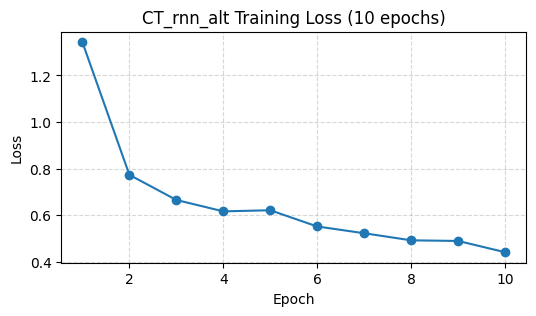

In [23]:
# CT_Task 5 — Train alt RNN for 10 epochs and plot loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Build tensors (batch-first: (B,T,F))
CT_X_bf = torch.from_numpy(X_train_std).float()     # expect X_train_std
CT_y = torch.from_numpy(y_train_np).long()         # expect y_train_np

CT_ds = TensorDataset(CT_X_bf, CT_y)
CT_loader = DataLoader(CT_ds, batch_size=32, shuffle=True)

CT_optimizer = torch.optim.Adam(list(CT_rnn_alt.parameters()) + list(CT_fc_alt.parameters()), lr=1e-3)
CT_criterion = nn.CrossEntropyLoss()

CT_train_losses = []
CT_NUM_EPOCHS = 10

for epoch in range(CT_NUM_EPOCHS):
    CT_rnn_alt.train()
    epoch_loss = 0.0
    total = 0
    for xb, yb in CT_loader:
        # forward (batch-first → time-first for RNN)
        # xb_tbf = xb.permute(..., ..., ...)      # (T,B,F)
        CT_optimizer.zero_grad()
        out_seq, h_n = CT_rnn_alt(xb)
        logits = CT_fc_alt(h_n[-1].squeeze(0))      # (B, NUM_CLASSES)
        loss = CT_criterion(logits, yb)
        loss.backward()
        CT_optimizer.step()
        epoch_loss += loss.item() * yb.size(0)
        total += yb.size(0)
    CT_train_losses.append(epoch_loss / total)

# Plot loss
plt.figure(figsize=(6,3))
plt.plot(range(1, CT_NUM_EPOCHS+1), CT_train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CT_rnn_alt Training Loss (10 epochs)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


---

### **6. Evaluation on Test Set**

**What we will measure**

- **Accuracy**: fraction of correctly classified sequences.
- **Confusion matrix**: shows where predictions go wrong by class.
- **Classification report**: precision, recall, and F1-score per class.

Why the confusion matrix matters: accuracy alone can hide *which* activities we confuse.  
For HAR, it is common to see confusions among **locomotion** classes (e.g., $ \text{WALKING} $ vs. $ \text{WALKING\_UPSTAIRS} $ vs. $ \text{WALKING\_DOWNSTAIRS} $).

**Evaluation protocol**

- Put the model in `eval` mode and **disable gradients**.
- Iterate over the **test loader**, collect all predictions and targets.
- Compute metrics and the confusion matrix.
- Visualize the confusion matrix as a heatmap.

We will also print a **few example predictions** to ground the numbers.




In [24]:
# Collect predictions on the test set

import torch
import numpy as np

model.eval()
all_logits = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)               # (batch, 6)
        all_logits.append(logits.cpu())
        all_targets.append(yb.cpu())

all_logits  = torch.cat(all_logits, dim=0)     # (N_test, 6)
all_targets = torch.cat(all_targets, dim=0)    # (N_test,)
all_preds   = all_logits.argmax(dim=1)         # (N_test,)


In [25]:
# Overall accuracy

test_acc = (all_preds == all_targets).float().mean().item()
print(f"Test accuracy: {test_acc*100:.2f}%")

# Show a few predictions
for i in range(5):
    t = int(all_targets[i])
    p = int(all_preds[i])
    print(f"Example {i}: true={ACTIVITY_MAP[t+1]:<20s} pred={ACTIVITY_MAP[p+1]:<20s}")


Test accuracy: 84.80%
Example 0: true=STANDING             pred=STANDING            
Example 1: true=STANDING             pred=STANDING            
Example 2: true=STANDING             pred=STANDING            
Example 3: true=STANDING             pred=STANDING            
Example 4: true=STANDING             pred=STANDING            


In [26]:
# Confusion matrix and classification report

from sklearn.metrics import confusion_matrix, classification_report

labels_idx = list(range(NUM_CLASSES))
labels_txt = [ACTIVITY_MAP[i+1] for i in labels_idx]

cm = confusion_matrix(all_targets.numpy(), all_preds.numpy(), labels=labels_idx)
print("Confusion Matrix (raw counts):")
print(cm)

print("\nClassification Report:")
print(classification_report(all_targets.numpy(), all_preds.numpy(), target_names=labels_txt, digits=3))


Confusion Matrix (raw counts):
[[391  66  39   0   0   0]
 [ 32 405  18  12   0   4]
 [ 11  44 363   1   0   1]
 [  1  22   0 404  64   0]
 [  0   2   0 104 426   0]
 [  0  27   0   0   0 510]]

Classification Report:
                    precision    recall  f1-score   support

           WALKING      0.899     0.788     0.840       496
  WALKING_UPSTAIRS      0.716     0.860     0.781       471
WALKING_DOWNSTAIRS      0.864     0.864     0.864       420
           SITTING      0.775     0.823     0.798       491
          STANDING      0.869     0.801     0.834       532
            LAYING      0.990     0.950     0.970       537

          accuracy                          0.848      2947
         macro avg      0.852     0.848     0.848      2947
      weighted avg      0.855     0.848     0.850      2947



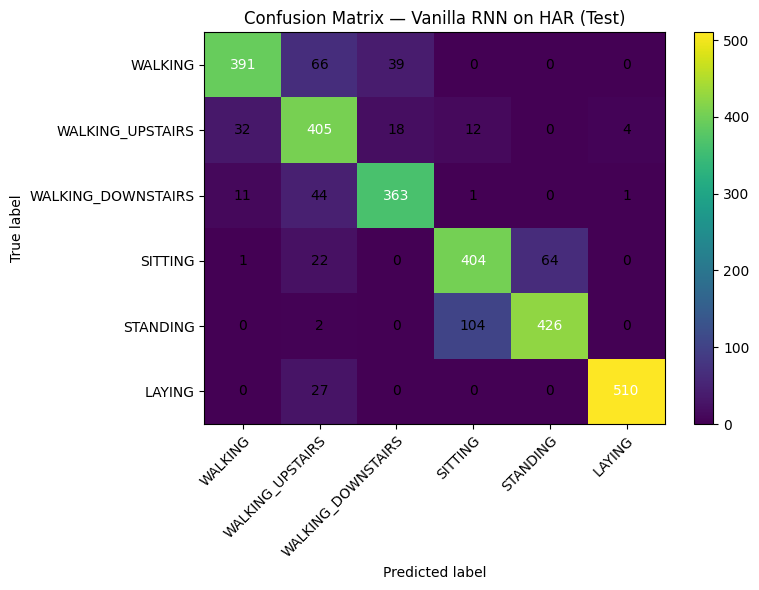

In [27]:
# Plot confusion matrix heatmap

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(NUM_CLASSES),
    yticks=np.arange(NUM_CLASSES),
    xticklabels=labels_txt,
    yticklabels=labels_txt,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix — Vanilla RNN on HAR (Test)"
)

# Rotate x tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells with counts
thresh = cm.max() / 2.0 if cm.size > 0 else 0
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [28]:
# Identify the most confused pairs (excluding the diagonal)

cm_np = cm.astype(np.int64)
cm_offdiag = cm_np.copy()
np.fill_diagonal(cm_offdiag, 0)

# Find top-k confusions
k = 5
flat_idx = np.argsort(cm_offdiag.ravel())[::-1][:k]
rows, cols = np.unravel_index(flat_idx, cm_offdiag.shape)

print("Top confusions (true -> predicted : count):")
for r, c in zip(rows, cols):
    if cm_offdiag[r, c] > 0:
        print(f"{labels_txt[r]:<20s} -> {labels_txt[c]:<20s} : {cm_offdiag[r, c]}")

Top confusions (true -> predicted : count):
STANDING             -> SITTING              : 104
WALKING              -> WALKING_UPSTAIRS     : 66
SITTING              -> STANDING             : 64
WALKING_DOWNSTAIRS   -> WALKING_UPSTAIRS     : 44
WALKING              -> WALKING_DOWNSTAIRS   : 39


**Reflection**

- **Accuracy**: We quantified overall performance, but more importantly, the **confusion matrix** showed *where* mistakes concentrate.  
- **Common patterns** we expect in HAR with a vanilla RNN:
  - Confusions within **locomotion** classes (e.g., $ \text{WALKING} $ vs. $ \text{WALKING\_UPSTAIRS} $).  
  - Static classes (**SITTING**, **STANDING**, **LAYING**) are often easier and less confused with locomotion.  
- **Why these confusions?**
  - The model compresses $128$ timesteps into a single hidden vector $h_T$. Some fine-grained temporal cues get lost.  
  - A plain RNN can struggle with **longer dependencies** due to vanishing gradients.  

**What could help next?**
- Larger hidden size (within CPU limits), a bit more training, or small regularization tweaks.  
- Architectures with **gates** (GRU/LSTM) that better preserve information over time.  
- 1D CNNs to extract local temporal patterns, then feed to an RNN (hybrid).  

➡️ In the **next notebook (NB03)**, we will **visualize hidden states** to see how the model internally organizes different activities, and connect that to the notion of vanishing gradients.

---


### **7. Reflection on Limitations**

**Theory & Discussion**

So far, we trained a **vanilla RNN classifier**. It works, but it has important **limitations**:

1. **Vanishing gradients problem**  
   - During backpropagation through time (BPTT), gradients are multiplied repeatedly by Jacobian terms.  
   - If these multipliers are smaller than 1, gradients shrink exponentially.  
   - Result: **early timesteps** in the sequence have little influence on weight updates.  
   - The model "forgets" information from the distant past.

2. **Compression bottleneck**  
   - We compress all $128$ timesteps into a **single hidden vector $h_T$**.  
   - Fine-grained temporal patterns (e.g., subtle differences between *WALKING* vs. *WALKING\_UPSTAIRS*) can be lost.  
   - This explains why the confusion matrix showed certain activities being mixed up.

3. **Limited capacity compared to CNNs or gated RNNs**  
   - CNNs can learn **local filters** that detect short-term motion signatures.  
   - LSTMs and GRUs use **gates** to decide *what to keep* and *what to forget*, making them much better at long-term dependencies.  
   - Our simple tanh-based RNN lacks such mechanisms.

**Reflection Prompts for Students**

- Why might some activities (e.g., **WALKING vs. WALKING\_UPSTAIRS**) be harder to classify than others (e.g., **SITTING vs. LAYING**)?  
- What kind of information might get lost when we compress $128 \times 9$ sensor readings into a single hidden vector?  
- If you were to design an improvement, how could **LSTMs** or **GRUs** help? (Hint: think about *gates* controlling the flow of information across time.)

**Looking Ahead**

This notebook showed us both the **power** and the **limits** of vanilla RNNs.  
In **NB03**, we will **peek inside the hidden states**: visualizing how they evolve, and directly observe why long sequences are tricky.  
This will naturally motivate more advanced architectures like **GRUs and LSTMs** in later notebooks.

---

### **7. Summary & Bridge to NB03**

**Summary**

In this notebook, we:

- Built and trained a **vanilla RNN classifier** for the Human Activity Recognition dataset.  
- Learned how to prepare sequential data for PyTorch RNNs.  
- Observed training curves (loss & accuracy) and tested performance.  
- Used a **confusion matrix** and **classification report** to see where the model struggles.  

Key insight:  
- **RNNs can learn sequential patterns** like walking vs. sitting, but compressing $128 \times 9$ signals into one hidden vector has limits.  
- **Vanilla RNNs** suffer from the *vanishing gradient problem*, making it difficult to capture long-term dependencies.  

**Bridge to NB03**

Next, in **Notebook 3**, we will:

- **Visualize hidden states** ($h_t$ over time) to peek inside the RNN’s memory.  
- See how activity signals are represented in hidden space.  
- Observe firsthand how information fades as sequences grow longer — the vanishing gradient problem.  

This will set the stage for introducing **gated RNNs (GRUs/LSTMs)** in later notebooks, which overcome these limitations.  

**Key Takeaways (NB02)**

- **RNNs process sequences step by step in time**, carrying hidden state $h_t$ forward.  
- A **vanilla RNN classifier** can learn to distinguish activities from raw inertial signals.  
- **Training & evaluation**: we used `CrossEntropyLoss`, tracked accuracy, and inspected confusion matrices.  
- **Limitations**:
  - Vanishing gradients weaken learning of long-term dependencies.  
  - Compressing 128 timesteps into one hidden vector can lose important temporal cues.  
- This motivates **visualizing hidden states** (NB03) and eventually moving to **LSTMs/GRUs** (Project 8).


